In [9]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sparentdir = os.path.dirname(parentdir)
sys.path.insert(0,parentdir)
sys.path.insert(0,sparentdir)

import datetime
import numpy as np
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import create
import generate
import recall
import simulations
import simsave
import load_curves

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib as mpl
import copy
import pickle
import numpy as np
import pandas as pd
import time
import seaborn as sns


N = 100
p = 0.5

r = 0.1
M = 30

set_of_Ss = np.linspace(0,5.0,51)
set_of_Cs = np.linspace(0.1,0.4,13)
s_space = np.linspace(-10.0,15.0,10001)

In [24]:
currentdir

'/home/dan/PycharmProjects/Recall/Paper/Figures2021'

In [2]:
recovered_s_control = np.load('./saves_recall/recovered_s_control_030p.npy')
recovered_s_hlesion = np.load('./saves_recall/recovered_s_hlesion_030p.npy')
recovered_s_control_lur = np.load('./saves_recall/recovered_s_control_lur_030p.npy')
recovered_s_hlesion_lur = np.load('./saves_recall/recovered_s_hlesion_lur_030p.npy')

error_known = np.load('./saves_recall/error_known_030p.npy')
error_dual = np.load('./saves_recall/error_dual_030p.npy')
error_mono = np.load('./saves_recall/error_mono_030p.npy')

proj_x_true = np.load('./saves_recall/proj_x_true_030p.npy')
proj_x_known = np.load('./saves_recall/proj_x_known_030p.npy')
proj_x_dual = np.load('./saves_recall/proj_x_dual_030p.npy')
proj_x_mono = np.load('./saves_recall/proj_x_mono_030p.npy')

In [3]:
# Define the Background distribution
k_back = 2.0
mu_back = 1.0
background_dist = stats.gamma(k_back, 0, mu_back/k_back)
dist_T_fortin  = stats.gamma(10.75,0,1/4.16666)

mu_P0 = mu_back
sigma_P0 = np.sqrt(mu_back*mu_back/k_back)
e_s2_P0 = mu_P0**2 + sigma_P0**2

In [4]:
def get_int_err(errors, dist, set_of_Ss):
    weights = dist.pdf(set_of_Ss)
    sum_prod = np.inner(errors.T,weights).sum()
    return sum_prod / np.inner(np.ones(errors.T.shape),weights).sum() 

In [5]:
def get_x_samples(dist, proj_x_true, proj_x_other1, proj_x_other2, proj_x_other3, set_of_Ss, n=50):
    samples = background_dist.rvs(n)
    
    x_true = np.zeros(n)
    x_other1 = np.zeros(n)
    x_other2 = np.zeros(n)
    x_other3 = np.zeros(n)
    
    for i in range(n):
        i_s = np.argmin(np.abs(samples[i]-set_of_Ss))
        idx = np.random.randint(0,len(proj_x_true[0]))      
        x_true[i]  = proj_x_true[i_s,idx]
        x_other1[i] = proj_x_other1[i_s,idx]
        x_other2[i] = proj_x_other2[i_s,idx]
        x_other3[i] = proj_x_other3[i_s,idx]
                        
    return x_true, x_other1, x_other2, x_other3

In [6]:
def get_RMSE(ss, rec_s):
    return np.sqrt(np.mean((rec_s.T-ss)**2, axis= 0))

In [12]:
t_max = 2000

weights = dist_T_fortin.pdf(set_of_Ss)/np.sum(dist_T_fortin.pdf(set_of_Ss))

i_c_k = np.argmin(np.mean(np.einsum('ijk,j -> ik', error_known[:,:,:t_max], weights), axis=1))
i_c_d = np.argmin(np.mean(np.einsum('ijk,j -> ik', error_dual[:,:,:t_max], weights), axis=1))
i_c_m = np.argmin(np.mean(np.einsum('ijk,j -> ik', error_mono[:,:,:t_max], weights), axis=1))

print(i_c_k, i_c_d, i_c_m)
#i_c_k = 0
#i_c_m = 0
#i_c_d = 0

9 12 12


Text(0.5, 0.98, 'pseudo noise 0.30; integrated over target; M=30')

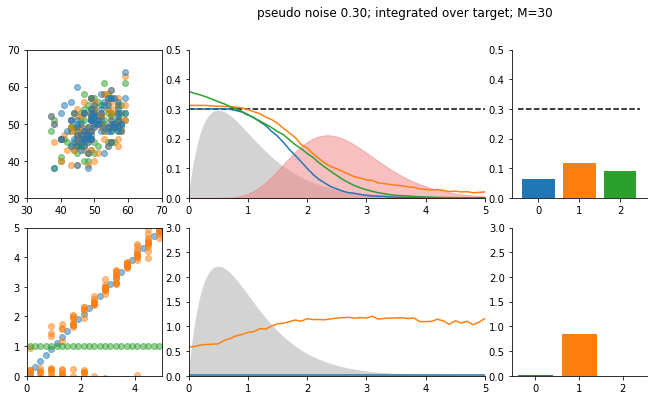

In [17]:
fig = plt.figure(figsize=(14,6))
plt.tight_layout()

gs = gridspec.GridSpec(2,5)

t_max = 1990

ax_rec = [plt.subplot(gs[0,0:1]), plt.subplot(gs[0,1:3]), plt.subplot(gs[0,3:4])]
ax_fam = [plt.subplot(gs[1,0:1]), plt.subplot(gs[1,1:3]), plt.subplot(gs[1,3:4])]


x_true, x_other1, x_other2, x_other3  = get_x_samples(background_dist, proj_x_true[i_c_k,:,:t_max], proj_x_known[ i_c_k,:,:t_max], proj_x_dual[ i_c_d,:,:t_max], proj_x_mono[ i_c_m,:,:t_max], set_of_Ss, n=100)
ax_rec[0].scatter(x_true, x_other1, alpha=0.5, zorder=10)
ax_rec[0].scatter(x_true, x_other2, alpha=0.5, zorder=5)
ax_rec[0].scatter(x_true, x_other3, alpha=0.5, zorder= 0)

ax_rec[0].set_xlim(xmin=30,xmax=70)
ax_rec[0].set_ylim(ymin=30, ymax=70)


ax_rec[1].plot(set_of_Ss, 0.3*np.ones(len(set_of_Ss)), 'k--')
ax_rec[1].plot(set_of_Ss, np.mean(error_known[ i_c_k,:,:t_max]/100,axis=1))
ax_rec[1].plot(set_of_Ss, np.mean(error_dual[ i_c_d,:,:t_max]/100,axis=1))
ax_rec[1].plot(set_of_Ss, np.mean(error_mono[ i_c_m,:,:t_max]/100,axis=1))
ax_rec[1].fill_between(np.linspace(-1,7,1000),np.zeros(1000), .4*background_dist.pdf(np.linspace(-1,7,1000)),
                           color= 'lightgray', zorder=0)

ax_rec[1].fill_between(np.linspace(-1,7,1000),np.zeros(1000), .4*dist_T_fortin.pdf(np.linspace(-1,7,1000)),
                           color= 'lightcoral', zorder=1, alpha=0.5)

ax_rec[1].set_xlim(xmin=-0.0,xmax=5)
ax_rec[1].set_ylim(ymin=0, ymax=0.5)
ax_rec[1].spines["top"].set_visible(False)
ax_rec[1].spines["right"].set_visible(False)

ax_rec[2].plot([-0.5,2.5],[0.3,0.3],'k--')
ax_rec[2].bar(0, get_int_err(error_known[i_c_k,:,:t_max]/100, dist_T_fortin, set_of_Ss))
ax_rec[2].bar(1, get_int_err(error_dual[i_c_d,:,:t_max]/100, dist_T_fortin, set_of_Ss))
ax_rec[2].bar(2, get_int_err(error_mono[i_c_m,:,:t_max]/100, dist_T_fortin, set_of_Ss))

ax_rec[2].set_ylim(ymin=0, ymax=0.5)
ax_rec[2].spines["top"].set_visible(False)
ax_rec[2].spines["right"].set_visible(False)

n=10
ax_fam[0].scatter(set_of_Ss[1::2], set_of_Ss[1::2], alpha = 0.5)
ax_fam[0].scatter(np.repeat(set_of_Ss[1::4],n), recovered_s_control[i_c_d,1::4,:n].flatten(), alpha=0.5)
ax_fam[0].scatter(set_of_Ss[1::2], np.ones(len(set_of_Ss[1::2])), alpha = 0.5)
ax_fam[0].set_xlim(xmin=-0.0,xmax=5)
ax_fam[0].set_ylim(ymin=-0.0,ymax=5)

ax_fam[1].plot(set_of_Ss, 0.01*np.ones(len(set_of_Ss)))
ax_fam[1].plot(set_of_Ss, get_RMSE(set_of_Ss, recovered_s_control[i_c_d,:,:t_max]))

dist_B = background_dist

ax_fam[1].fill_between(np.linspace(-1,7,1000),np.zeros(1000), 3.0*dist_B.pdf(np.linspace(-1,7,1000)),
                           color= 'lightgray', zorder=0)

ax_fam[1].set_xlim(xmin=-0.0,xmax=5)
ax_fam[1].set_ylim(ymin=0, ymax=3)
ax_fam[1].spines["top"].set_visible(False)
ax_fam[1].spines["right"].set_visible(False)

ax_fam[2].bar(0, 0.01)
ax_fam[2].bar(1, get_int_err(get_RMSE(set_of_Ss, recovered_s_control[i_c_d,:,:t_max]), background_dist, set_of_Ss))
ax_fam[2].bar(2, 0)

ax_fam[2].set_ylim(ymin=0, ymax=3)
ax_fam[2].set_ylim(ymin=0, ymax=3)
ax_fam[2].spines["top"].set_visible(False)
ax_fam[2].spines["right"].set_visible(False)

plt.suptitle('pseudo noise 0.30; integrated over target; M=30')

In [14]:
t_max = 2000

weights = background_dist.pdf(set_of_Ss)/np.sum(background_dist.pdf(set_of_Ss))

i_c_k = np.argmin(np.mean(np.einsum('ijk,j -> ik', error_known[:,:,:t_max], weights), axis=1))
i_c_d = np.argmin(np.mean(np.einsum('ijk,j -> ik', error_dual[:,:,:t_max], weights), axis=1))
i_c_m = np.argmin(np.mean(np.einsum('ijk,j -> ik', error_mono[:,:,:t_max], weights), axis=1))

print(i_c_k, i_c_d, i_c_m)
#i_c_k = 0
#i_c_m = 0
#i_c_d = 0

1 12 2


Text(0.5, 0.98, 'pseudo noise 0.30; integrated over background; M=30')

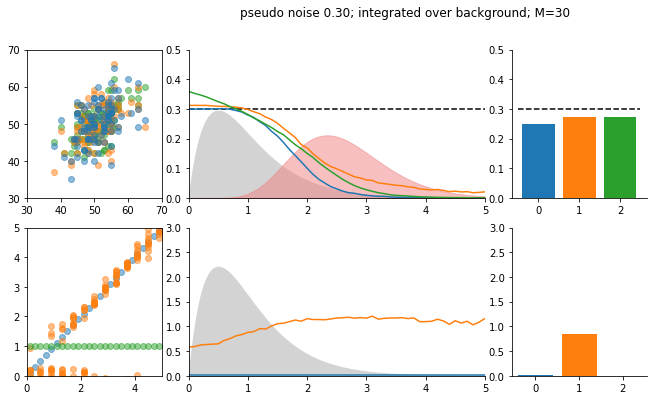

In [16]:
fig = plt.figure(figsize=(14,6))
plt.tight_layout()

gs = gridspec.GridSpec(2,5)

t_max = 1990

ax_rec = [plt.subplot(gs[0,0:1]), plt.subplot(gs[0,1:3]), plt.subplot(gs[0,3:4])]
ax_fam = [plt.subplot(gs[1,0:1]), plt.subplot(gs[1,1:3]), plt.subplot(gs[1,3:4])]


x_true, x_other1, x_other2, x_other3  = get_x_samples(background_dist, proj_x_true[i_c_k,:,:t_max], proj_x_known[ i_c_k,:,:t_max], proj_x_dual[ i_c_d,:,:t_max], proj_x_mono[ i_c_m,:,:t_max], set_of_Ss, n=100)
ax_rec[0].scatter(x_true, x_other1, alpha=0.5, zorder=10)
ax_rec[0].scatter(x_true, x_other2, alpha=0.5, zorder=5)
ax_rec[0].scatter(x_true, x_other3, alpha=0.5, zorder= 0)

ax_rec[0].set_xlim(xmin=30,xmax=70)
ax_rec[0].set_ylim(ymin=30, ymax=70)


ax_rec[1].plot(set_of_Ss, 0.3*np.ones(len(set_of_Ss)), 'k--')
ax_rec[1].plot(set_of_Ss, np.mean(error_known[ i_c_k,:,:t_max]/100,axis=1))
ax_rec[1].plot(set_of_Ss, np.mean(error_dual[ i_c_d,:,:t_max]/100,axis=1))
ax_rec[1].plot(set_of_Ss, np.mean(error_mono[ i_c_m,:,:t_max]/100,axis=1))
ax_rec[1].fill_between(np.linspace(-1,7,1000),np.zeros(1000), .4*background_dist.pdf(np.linspace(-1,7,1000)),
                           color= 'lightgray', zorder=0)

ax_rec[1].fill_between(np.linspace(-1,7,1000),np.zeros(1000), .4*dist_T_fortin.pdf(np.linspace(-1,7,1000)),
                           color= 'lightcoral', zorder=1, alpha=0.5)

ax_rec[1].set_xlim(xmin=-0.0,xmax=5)
ax_rec[1].set_ylim(ymin=0, ymax=0.5)
ax_rec[1].spines["top"].set_visible(False)
ax_rec[1].spines["right"].set_visible(False)

ax_rec[2].plot([-0.5,2.5],[0.3,0.3],'k--')
ax_rec[2].bar(0, get_int_err(error_known[i_c_k,:,:t_max]/100, background_dist, set_of_Ss))
ax_rec[2].bar(1, get_int_err(error_dual[i_c_d,:,:t_max]/100, background_dist, set_of_Ss))
ax_rec[2].bar(2, get_int_err(error_mono[i_c_m,:,:t_max]/100, background_dist, set_of_Ss))

ax_rec[2].set_ylim(ymin=0, ymax=0.5)
ax_rec[2].spines["top"].set_visible(False)
ax_rec[2].spines["right"].set_visible(False)

n=10
ax_fam[0].scatter(set_of_Ss[1::2], set_of_Ss[1::2], alpha = 0.5)
ax_fam[0].scatter(np.repeat(set_of_Ss[1::4],n), recovered_s_control[i_c_d,1::4,:n].flatten(), alpha=0.5)
ax_fam[0].scatter(set_of_Ss[1::2], np.ones(len(set_of_Ss[1::2])), alpha = 0.5)
ax_fam[0].set_xlim(xmin=-0.0,xmax=5)
ax_fam[0].set_ylim(ymin=-0.0,ymax=5)

ax_fam[1].plot(set_of_Ss, 0.01*np.ones(len(set_of_Ss)))
ax_fam[1].plot(set_of_Ss, get_RMSE(set_of_Ss, recovered_s_control[i_c_d,:,:t_max]))

dist_B = background_dist

ax_fam[1].fill_between(np.linspace(-1,7,1000),np.zeros(1000), 3.0*dist_B.pdf(np.linspace(-1,7,1000)),
                           color= 'lightgray', zorder=0)

ax_fam[1].set_xlim(xmin=-0.0,xmax=5)
ax_fam[1].set_ylim(ymin=0, ymax=3)
ax_fam[1].spines["top"].set_visible(False)
ax_fam[1].spines["right"].set_visible(False)

ax_fam[2].bar(0, 0.01)
ax_fam[2].bar(1, get_int_err(get_RMSE(set_of_Ss, recovered_s_control[i_c_d,:,:t_max]), background_dist, set_of_Ss))
ax_fam[2].bar(2, 0)

ax_fam[2].set_ylim(ymin=0, ymax=3)
ax_fam[2].set_ylim(ymin=0, ymax=3)
ax_fam[2].spines["top"].set_visible(False)
ax_fam[2].spines["right"].set_visible(False)

plt.suptitle('pseudo noise 0.30; integrated over background; M=30')